In [ ]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import numpy as np
import matplotlib.pyplot as plt
import utils.configuration as cf
import utils.datasets as ud
from models.mnist_conv import mnist_conv
from scipy.interpolate import make_interp_spline

# Fix the random seed

In [2]:
random_seed = 0
cf.seed_torch(random_seed)

# Configure the experiment

In [3]:
conf_args = {#
    # data specification
    'data_file':"../../datasets",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':2, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':30,
    # optimizer
    'delta':1.0, 'lr':0.1, 'lamda_0':1e-4, 'lamda_1':0.01, 'optim':"LinBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[10.,10.,10.],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [4]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs)
best_model = train.best_model(mnist_conv(**model_kwargs).to(conf.device))

# Weight initialization

In [5]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_bias_uniform_(model, 0,conf.r[0], ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2], ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Conv2d, conv_group=conf.conv_group)
    maf.sparsify_(model, conf.sparse_init, ltype = nn.Linear)
    model = model.to(conf.device)    
    return model

model = init_weights(conf,model)

# Optimizer

In [6]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)
    
    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)
    
    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg": # change 'reg' to reg2 if want to use l1_l2 regularization as was previously
        opt = op.NuclearLinBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          # apply nuclear regularization to the conv layers, switch to l1 reg.reg_l1(lamda=conf.lamda_1) if needed
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_linear(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg2, 'momentum':conf.beta,'delta':conf.delta},
                          {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_linear(lamda=conf.lamda_1), 'momentum':conf.beta,'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])            
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg([{'params': weights_conv, 'lr' : conf.lr, 'reg' : reg.reg_nuclear_conv(lamda=conf.lamda_0),'delta':conf.delta},
                           {'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda_1),'delta':conf.delta},
                           {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 =  reg.reg_l1(lamda=conf.lamda_1)
        
            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2
        
        conf.weight_reg = weight_reg
        
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

# Dataset

In [7]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# History and Runs

In [8]:
# Initialize history
tracked = ['loss', 'node_sparse']
train_hist = {}
val_hist = {}

# Training

In [9]:
# -----------------------------------------------------------------------------------
# Reinit weights and the corresponding optimizer
# -----------------------------------------------------------------------------------
model = init_weights(conf, model)
opt, scheduler = init_opt(conf, model)

# Initialize history for tracking both metrics
effective_rank_history = []
test_accuracy_history = []

# -----------------------------------------------------------------------------------
# train the model
# -----------------------------------------------------------------------------------
for epoch in range(conf.epochs):
    print(25*"<>")
    print(50*"|")
    print(25*"<>")
    print('Epoch:', epoch)

    # ------------------------------------------------------------------------
    # train step, log the accuracy and loss
    # ------------------------------------------------------------------------
    train_data = train.train_step(conf, model, opt, train_loader)

    # update history
    for key in tracked:
        if key in train_data:
            var_list = train_hist.setdefault(key, [])
            var_list.append(train_data[key])           

    # ------------------------------------------------------------------------
    # validation step
    # ------------------------------------------------------------------------
    val_data = train.validation_step(conf, model, opt, valid_loader)

    # update validation history
    for key in tracked:
        if key in val_data:
            var = val_data[key]
            if isinstance(var, list):
                for i, var_loc in enumerate(var):
                    key_loc = key+"_" + str(i)
                    var_list = val_hist.setdefault(key_loc, [])
                    val_hist[key_loc].append(var_loc)
            else:
                var_list = val_hist.setdefault(key, [])
                var_list.append(var)   

    # Track effective rank ratio
    current_rank_ratio = maf.linear_effective_rank_ratio(model, epsilon=1e-3)
    effective_rank_history.append(current_rank_ratio)
    
    # Also track test accuracy each epoch
    test_data = train.test(conf, model, test_loader, verbosity=0)
    test_accuracy_history.append(test_data['acc'])
    
    print(f'Linear Layer Effective Rank Ratio (ε=1e-3): {current_rank_ratio}')
    print(f'Test Accuracy: {test_data["acc"]:.4f}')

    scheduler.step(train_data['loss'])
    print("Learning rate:", opt.param_groups[0]['lr'])
    best_model(train_data['acc'], val_data['acc'], model=model)

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0
--------------------------------------------------
Train Accuracy: 0.671578947368421
Train Loss: 704.2147147357464
--------------------------------------------------
Validation Accuracy: 0.718
Non-zero kernels: 0.9858173076923077
Linear sparsity: 0.9970986460348162
Overall sparsity: 0.9920880720281614
Node sparsity: [1.0, 1.0]
Regularization values per group: [0.3091435880661011, tensor(4.0510), 0.0]
Linear Layer Effective Rank Ratio (ε=1e-3): 0.99609375
Test Accuracy: 0.7157
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
--------------------------------------------------
Train Accuracy: 0.7962456140350878
Train Loss: 241.0703847706318
--------------------------------------------------
Validatio

# Evaluation

In [10]:
train.test(conf, best_model.best_model, test_loader) 
print(f'Convolution kernel sparsity: {maf.conv_sparsity(best_model.best_model)}')
print(f'Linear sparsity: {maf.linear_sparsity(best_model.best_model)}')
linear_rank_ratio = maf.linear_effective_rank_ratio(best_model.best_model, epsilon=1e-3)
print(f'Linear Layer Effective Rank Ratio (ε=1e-3): {linear_rank_ratio}')
fc_layer_ranks = maf.get_linear_layer_ranks(best_model.best_model, epsilon=1e-3)
for layer_name, rank_ratio in fc_layer_ranks.items():
    print(f'Layer {layer_name} rank ratio (ε=1e-3): {fc_layer_ranks[layer_name]}')
print("\nSingular values of linear layers:")
for name, m in best_model.best_model.named_modules():
    if isinstance(m, torch.nn.Linear):
        _, S, _ = torch.svd(m.weight, some=True)
        print(f"Layer {name} singular values: {S[:10]}")  # Show first 10 values

--------------------------------------------------
Test Accuracy: 0.8625
Convolution kernel sparsity: 0.9884615384615385
Linear sparsity: 0.9970986460348162
Linear Layer Effective Rank Ratio (ε=1e-3): 0.66875
Layer layers2.0 rank ratio (ε=1e-3): 0.4375
Layer layers2.2 rank ratio (ε=1e-3): 0.9

Singular values of linear layers:
Layer layers2.0 singular values: tensor([76.1110, 17.4244,  7.5862,  4.7430,  4.5965,  3.7036,  1.6261,  1.0567,
         0.9300,  0.8508], grad_fn=<SliceBackward0>)
Layer layers2.2 singular values: tensor([7.0966e+01, 3.7494e+00, 8.8212e-01, 7.4230e-01, 5.4214e-01, 5.3797e-01,
        3.3462e-01, 2.5849e-01, 1.7910e-01, 3.4043e-06],
       grad_fn=<SliceBackward0>)


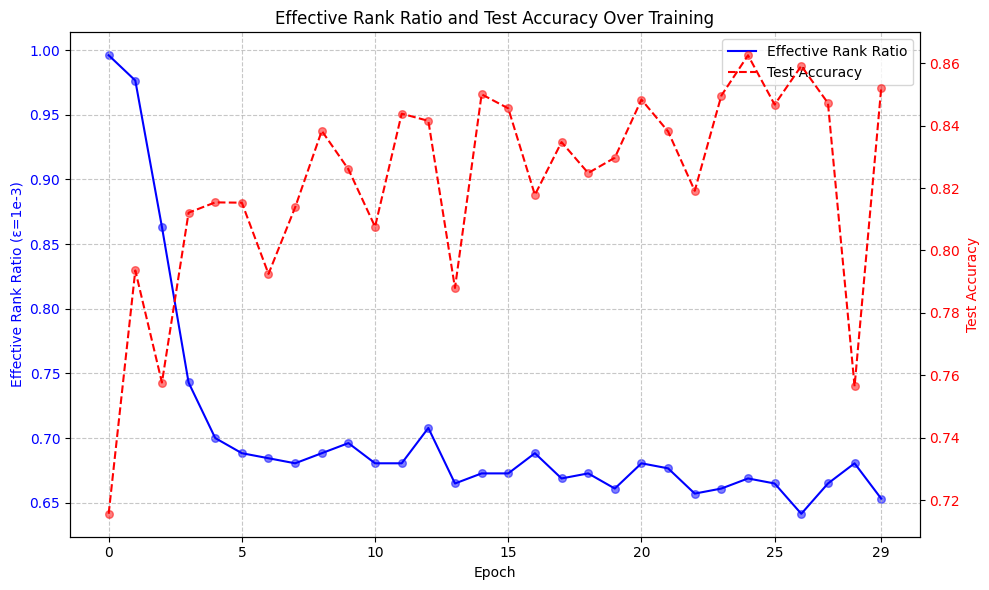

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create arrays for plotting
x = np.array(range(len(effective_rank_history)))

# Plot effective rank ratio (left y-axis)
color1 = 'blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Effective Rank Ratio (ε=1e-3)', color=color1)

# Scatter plot of original data points
ax1.scatter(x, effective_rank_history, color=color1, s=30, alpha=0.5)

# Simple line connecting the points
line1 = ax1.plot(x, effective_rank_history, linestyle='-', color=color1, 
                 label='Effective Rank Ratio')

ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.7)

# Create second y-axis for test accuracy
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Test Accuracy', color=color2)

# Scatter plot of original accuracy data
ax2.scatter(x, test_accuracy_history, color=color2, s=30, alpha=0.5)

# Simple line connecting the points
line2 = ax2.plot(x, test_accuracy_history, linestyle='--', color=color2, 
                label='Test Accuracy')

ax2.tick_params(axis='y', labelcolor=color2)

# Modify x-axis to show labels at multiples of 5
max_epoch = len(effective_rank_history) - 1
xticks = [i for i in range(0, max_epoch+1, 5)]
if max_epoch not in xticks:
    xticks.append(max_epoch)
plt.xticks(xticks)

# Add a legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title('Effective Rank Ratio and Test Accuracy Over Training')
plt.tight_layout()
plt.show()